# Simulação de um único agente

In [65]:
import os
import sys
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

sys.path.insert(0, 'agents')
sys.path.insert(0, 'environments')

In [66]:
# Iniciando agente e ambiente

import env_abp_target_finding as env_class
import ps_agent_basic_alternativo as agent_class

L = 100

Pe = 100
#Pe = (v*tao)/L #Péclet number

l = 1
#l = v/(D_theta*L) #persistence of directed motion in ABP phase

dt = 1

tao = int(dt/1e-4)
#tao = L*L/(4*D)

# Parâmetros de damping em função de Pe, de acordo com o artigo (seção de Métodos)
param_dict = {
    5:{
        'gamma_damping' : 1e-7,
        'eta_glow_damping' : 1e-2
        },
    10:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    20:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    50:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-2
        },
    100:{
        'gamma_damping' : 1e-5,
        'eta_glow_damping' : 1e-2
        }
}

gamma_damping = param_dict[Pe]['gamma_damping']
eta_glow_damping = param_dict[Pe]['eta_glow_damping']
policy_type = 'standard' #'softmax' #Cálculo da probabilidade do agente de acordo com a matrix H
beta_softmax = 1

num_trials = 100 # Quantidade máxima de episódios para o aprendizado
max_steps_per_trial = 20*tao # De acordo com o artigo

# Inicia ambiente e agente
env = env_class.TaskEnvironment(L, Pe, l, tao, dt)
agent = agent_class.BasicPSAgent(
        env.num_actions, env.num_percepts_list,
        gamma_damping, eta_glow_damping, 
        policy_type, beta_softmax
    )

# Inicia matriz de probabilidade de acordo com o artigo
for step in range(env.max_steps_per_trial):
    for state in range(env.num_states):
        percept = agent.percept_preprocess([state,step])
        if state == 0:
            agent.h_matrix[1, percept] = 1e-2
            agent.h_matrix[0, percept] = 1 - 1e-2

        elif state == 1:
            agent.h_matrix[1, percept] = 1e-3
            agent.h_matrix[0, percept] = 1 - 1e-3

# Matriz h0 inicial é estática
agent.h0_matrix = agent.h_matrix

In [67]:
# Inicia simulação e aprendizado

posicoes = [] # Guarda as posições a cada passo
h_matrix = [] # Guarda a matriz de probabilidade
statistics = [] # Guarda os resultados do processo de aprendizado

# Loop sobre os episódios
for i_trial in range(num_trials):
    ### Condições iniciais do episódio
    env.reset_target() #Resta a posição do target
    env.r = np.array([0, 0]) # Agentes sempre iniciam o episódio na posição zero
    env.reset_agent_state(1) # Ao inicio de cada episódio, reseta o agente no estado ABP (1)
    agent.g_matrix = np.zeros((agent.num_actions, agent.num_percepts), dtype=np.float64) # Zera a matriz de estados acessados a cada novo episódio, conforme o artigo

    # Inicia passos de aprendizado do episódio
    for t in range(max_steps_per_trial):
        observation = env.state_observation() # Observação: [Estado (0,1), Quantidade de passos no estado (0,...,tao-1)]
        action = agent.deliberate(observation) # Agente toma uma ação (0 = Manter estado, 1 = Trocar de estado)
        reward, done = env.update_environment(action) # Atualiza o ambiente de acordo com a ação do agente
        agent.learn(reward) # Realiza aprendizado do agente de acordo com a recompensa recebida

        # Salvo as posições em cada passo do agente para episódios específicos
        if (i_trial in [0,20,50,99]):
            posicoes.append([
                    i_trial, t, env.r[0], env.r[1],
                    env.target_position[0], env.target_position[1],
                    observation[0], observation[1]
            ])
                   
        #Se o agente encontrou o target
        if done: 
            # Salva dos dados
            statistics.append([i_trial, t, t/tao])
            # Printa as informações do episódio
            print([i_trial, t, t/tao])
            # Finaliza o episódio
            break

# Salva matriz H após término dos episódios
h_matrix.append([i_trial, h_matrix])

KeyboardInterrupt: 

In [ ]:
# Evolução do aprendizado
db_stats = pd.DataFrame(statistics, columns = ['i_trial', 't', 't_tao'])

alt.Chart(db_stats).mark_line(color = 'black').encode(
    x = 'i_trial',
    y = 't_tao'
)

alt.Chart(...)

In [ ]:
db = pd.DataFrame(
    posicoes, 
    columns = ['i_trial','t',
               'x','y',
               'x_target','y_target',
               'state','counter'])

db

In [ ]:
(alt.Chart(db.query('i_trial == 0')).mark_circle().encode(
    x = 'x',
    y = 'y',
    color = 'state:N'
) | alt.Chart(db.query('i_trial == 20')).mark_circle().encode(
    x = 'x',
    y = 'y',
    color = 'state:N'
)).properties(title = 'Episódio 0 e 20') & (alt.Chart(db.query('i_trial == 50')).mark_circle().encode(
    x = 'x',
    y = 'y',
    color = 'state:N'
) | alt.Chart(db.query('i_trial == 99')).mark_circle().encode(
    x = 'x',
    y = 'y',
    color = 'state:N'
)).properties(title = 'Episódio 50 e 99')

alt.VConcatChart(...)

MovieWriter ffmpeg unavailable; using Pillow instead.


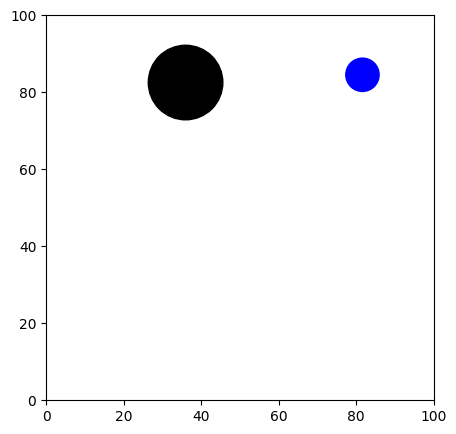

In [ ]:
# Gerando gifs dos movimentos

import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera

trial = 99

target_x = db.query(f'i_trial == {trial}')['x_target'].values[-1]
target_y = db.query(f'i_trial == {trial}')['y_target'].values[-1]

x_data = db.query(f'i_trial == {trial}')['x'].values[:1000]
y_data = db.query(f'i_trial == {trial}')['y'].values[:1000]

states = db.query(f'i_trial == {trial}')['state'].map({0:'blue',1:'orange'}).values
color = states

fig = plt.figure(figsize=[5, 5])
camera = Camera(fig)

# Raio das partículas de acordo com o tamanho da figura
points_whole_ax = 5 * 0.8 * 72    # 1 point = dpi / 72 pixels
radius = 0.05*L
points_radius = 2 * radius / 1.0 * points_whole_ax

ax = plt.axes(xlim=(0, L), ylim=(0, L))

for i in range(len(x_data)):
    plt.scatter(
        *np.array([[x_data[i],target_x], [y_data[i],target_y]]), 
        c=np.array([color[i],'black']), 
        s=[points_radius/5,points_radius]
    )
    camera.snap()

anim = camera.animate(blit=True)
anim.save(f'scatter_{trial}.gif', fps=100, dpi=200)

# Simulando multiplos agentes

In [71]:
import os
import sys
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

sys.path.insert(0, 'agents')
sys.path.insert(0, 'environments')

In [72]:
import env_abp_target_finding as env_class
import ps_agent_basic_alternativo as agent_class

L = 100

Pe = 100
#Pe = (v*tao)/L #Péclet number

l = 1
#l = v/(D_theta*L) #persistence of directed motion in ABP phase

dt = 1

tao = int(dt/1e-4)
#tao = L*L/(4*D)

param_dict = {
    5:{
        'gamma_damping' : 1e-7,
        'eta_glow_damping' : 1e-2
        },
    10:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    20:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-3
        },
    50:{
        'gamma_damping' : 1e-6,
        'eta_glow_damping' : 1e-2
        },
    100:{
        'gamma_damping' : 1e-5,
        'eta_glow_damping' : 1e-2
        }
}
#parameters for the agent - explanations can be found in the comments inside the agent file
gamma_damping = param_dict[Pe]['gamma_damping']
eta_glow_damping = param_dict[Pe]['eta_glow_damping']
policy_type = 'standard' #'softmax'
beta_softmax = 1

#set number of trials and maximum number of steps in each trial
n_agentes = 50
num_trials = 200
max_steps_per_trial = 20*tao

h_matrix = [] #guarda as probabilidades
statistics = [] #guarda os resultados do processo de aprendizado

target_position_list = [np.array([
            np.random.rand()*L, 
            np.random.rand()*L
        ]) for i in range(max_steps_per_trial)]

In [ ]:
for i_agente in range(0, n_agentes):

    print(i_agente)

    # Inicia ambiente e agente
    env = env_class.TaskEnvironment(L, Pe, l, tao, dt)
    agent = agent_class.BasicPSAgent(
        env.num_actions, env.num_percepts_list,
        gamma_damping, eta_glow_damping, 
        policy_type, beta_softmax
    )

    # Inicia matriz de probabilidade de acordo com o artigo
    for step in range(env.max_steps_per_trial):
        for state in range(env.num_states):
            percept = agent.percept_preprocess([state,step])
            if state == 0:
                agent.h_matrix[1, percept] = 1e-2
                agent.h_matrix[0, percept] = 1 - 1e-2

            elif state == 1:
                agent.h_matrix[1, percept] = 1e-3
                agent.h_matrix[0, percept] = 1 - 1e-3

    # Matriz h0 inicial é estática
    agent.h0_matrix = agent.h_matrix

    # Loop sobre os episódios
    for i_trial in range(num_trials):
        ### Condições iniciais do episódio
        env.target_position = target_position_list[i_trial] #agentes enfrentam um target pré definido para o episódio
        env.r = np.array([0, 0]) # Agentes sempre iniciam o episódio na posição zero 
        env.reset_agent_state(1) # Ao inicio de cada episódio, reseta o agente no estado ABP (1)
        agent.g_matrix = np.zeros((agent.num_actions, agent.num_percepts), dtype=np.float64) # Zera a matriz de estados acessados a cada novo episódio, conforme o artigo

        # Inicia passos de aprendizado do episódio
        for t in range(max_steps_per_trial):
            observation = env.state_observation() # Observação: [Estado (0,1), Quantidade de passos no estado (0,...,tao-1)]
            action = agent.deliberate(observation) # Agente toma uma ação (0 = Manter estado, 1 = Trocar de estado)
            reward, done = env.update_environment(action) # Atualiza o ambiente de acordo com a ação do agente
            agent.learn(reward) # Realiza aprendizado do agente de acordo com a recompensa recebida

            #Se o agente encontrou o target
            if done: 
                # Salva dos dados
                statistics.append([i_trial, i_agente, t, t/tao])
                # Printa as informações do episódio
                print([i_agente, i_trial, t, t/tao])
                # Finaliza o episódio
                break
    
    # Salva matriz H após término dos episódios
    h_matrix.append([i_agente, i_trial, h_matrix])

In [74]:
pd.DataFrame(h_matrix).to_csv('h_matrix.csv', index = False)
db = pd.DataFrame(statistics, columns = ['i_trial', 'i_agente', 't', 't_tao'])
db.to_csv('statistics.csv', index = False)
db

i_trial  i_agente       t    t_tao
0          0         0  128967  12.8967
1          1         0   16047   1.6047
2          2         0    8464   0.8464
3          3         0    6462   0.6462
4          4         0    7643   0.7643
..       ...       ...     ...      ...
759      159         3    8046   0.8046
760      160         3    2408   0.2408
761      161         3   16397   1.6397
762      162         3    8440   0.8440
763      163         3    4814   0.4814

[764 rows x 4 columns]

In [78]:
errorbar = alt.Chart(db).mark_errorband(extent = 'ci', borders = True, color = 'black').encode(
        x = 'i_trial', y = 't_tao'
)
mean = alt.Chart(db).mark_circle(size = 10).encode(
        x = 'i_trial', y = 'mean(t_tao)'
)

errorbar + mean

alt.LayerChart(...)

<Axes: >

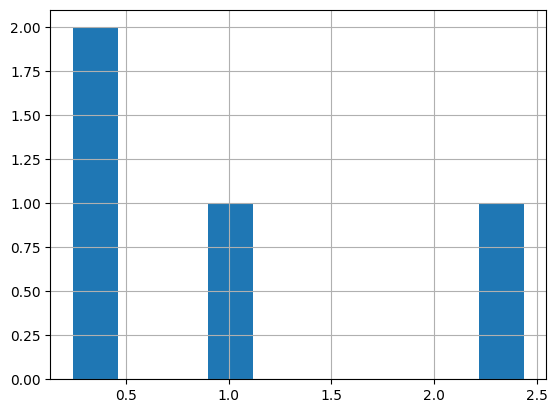

In [ ]:
db.drop_duplicates(subset = ['i_agente'], keep = 'last')['t_tao'].hist()